# Training

In [0]:
!pip install scikit-image opencv-python imutils

Importing libraries.

In [0]:
%tensorflow_version 1.x
from skimage import measure, transform
import matplotlib.pyplot as plt
from keras import backend as K
import nibabel as nib
import numpy as np
import glob
import math

Connect google drive if needed.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Saving names of scans in a list from dataset directory.

In [0]:
files = (glob.glob("dataset/*.nii.gz"))

**Create X_train and Y_train arrays.**

Total training samples: 6400

Size of single sample in X (LR): 32

Size of single sample in Y (HR): 64

In [0]:
f_sub = 64
f_sub_x = 32
num_scans = 64

org_scans = np.ndarray(shape=(64, 256, 320, 320, 1), dtype='uint8')
scans_test = np.ndarray(shape=(111, 256, 320, 320, 1), dtype='uint8')

X_train = np.ndarray(shape=(num_scans*100, f_sub_x, f_sub_x, f_sub_x, 1), dtype='uint8')     
Y_train = np.ndarray(shape=(num_scans*100, f_sub, f_sub, f_sub, 1), dtype='uint8')

Dividing original scans into 64 *x* 64 *x* 64 samples.

In [0]:
count = -1
scan_no = -1
for file in files[:num_scans]:
  scan_no = scan_no + 1
  
  #Using nibabel library to work with .nii.gz files
  img = nib.load(file)
  img_data = img.get_fdata()
  img_data = img_data/(np.amax(img_data))
  img_data = img_data * 255
  img_data = np.array(img_data, dtype='uint8')

  img_data.shape = img_data.shape + (1,)
  org_scans[scan_no, :, :, :] = img_data
  
  x = 0
  y = 0
  z = 0
  for i in range(4):
    y = 0
    for j in range(5):
      z = 0
      for k in range(5):
        count = count + 1
        temp = img_data[x:x+f_sub, y:y+f_sub, z:z+f_sub].copy()
        Y_train[count, :, :, :] = temp
        z = z + 64
      y = y + 64
    x = x + 64
  
print(count)

6399


**Populating X_train and Y_train arrays.**

The HR samples are double the size of LR samples.

Thus scaling factor: 2

In [0]:
for i in range(num_scans*100):
  X_train[i, :, :, :] = Y_train[i, ::2, ::2, ::2]

PSNR function for training.

In [0]:
def PSNR(y_true, y_pred):
    max_pixel = 255.0
    return 10.0 * (1.0 / math.log(10)) * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))

Importing libraries for creating model.

In [0]:
from keras.layers.convolutional import Conv2D, Conv3D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Activation
from keras.layers import Conv3DTranspose
from keras.models import Sequential

**Generating model.**

In [0]:
model1 = Sequential()
model1.add(Conv3D(filters=56, kernel_size=(5,5,5),strides=(1,1,1),padding='same',input_shape=(None, None, None, 1),activation='relu'))

model1.add(Conv3D(filters=16, kernel_size=(1,1,1),strides=(1,1,1),padding='same',activation='relu'))

model1.add(Conv3D(filters=16, kernel_size=(3,3,3),strides=(1,1,1),padding='same',activation='relu'))
model1.add(Conv3D(filters=16, kernel_size=(3,3,3),strides=(1,1,1),padding='same',activation='relu'))
model1.add(Conv3D(filters=16, kernel_size=(3,3,3),strides=(1,1,1),padding='same',activation='relu'))
model1.add(Conv3D(filters=16, kernel_size=(3,3,3),strides=(1,1,1),padding='same',activation='relu'))

model1.add(Conv3D(filters=56, kernel_size=(1,1,1),strides=(1,1,1),padding='same',activation='relu'))

model1.add(Conv3DTranspose(filters=1, kernel_size=(9,9,9),strides=(2,2,2),padding='same',activation='relu'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, None, None, None,  7056      
_________________________________________________________________
conv3d_9 (Conv3D)            (None, None, None, None,  912       
_________________________________________________________________
conv3d_10 (Conv3D)           (None, None, None, None,  6928      
_________________________________________________________________
conv3d_11 (Conv3D)           (None, None, None, None,  6928      
_________________________________________________________________
conv3d_12 (Conv3D)           (None, None, None, None,  6928      
_________________________________________________________________
conv3d_13 (Conv3D)           (None, None, None, None,  6928      
_________________________________________________________________
conv3d_14 (Conv3D)           (None, None, None, None, 

**Training the model.**

In [0]:
model1.compile(loss='mean_squared_error', optimizer='adam', metrics=[PSNR, 'accuracy'])
hist1 = model1.fit(X_train, Y_train, epochs=750, batch_size=32)

Epoch 1/750
6400/6400 [==============================] - 46s 7ms/step - loss: 137.1685 - PSNR: 28.5222 - acc: 0.1940
Epoch 2/750
6400/6400 [==============================] - 46s 7ms/step - loss: 40.6112 - PSNR: 32.1649 - acc: 0.2097
Epoch 3/750
6400/6400 [==============================] - 46s 7ms/step - loss: 31.8586 - PSNR: 33.1869 - acc: 0.2192
Epoch 4/750
6400/6400 [==============================] - 46s 7ms/step - loss: 30.4386 - PSNR: 33.4427 - acc: 0.2226
Epoch 5/750
6400/6400 [==============================] - 46s 7ms/step - loss: 28.7524 - PSNR: 33.6633 - acc: 0.2245
Epoch 6/750
6400/6400 [==============================] - 46s 7ms/step - loss: 26.3662 - PSNR: 34.0370 - acc: 0.2298
Epoch 7/750
6400/6400 [==============================] - 46s 7ms/step - loss: 27.7895 - PSNR: 33.8363 - acc: 0.2280
Epoch 8/750
6400/6400 [==============================] - 46s 7ms/step - loss: 23.4783 - PSNR: 34.4964 - acc: 0.2377
Epoch 9/750
6400/6400 [==============================] - 46s 7ms/step -

**Saving the model and training history.**

In [0]:
import pickle
model1.save('3Dfsrcnn.h5')
with open('/content/drive/My Drive/history.p', 'wb') as fp:
    pickle.dump(hist1.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Using the model

PSNR function for testing.

In [0]:
def psnr(y_true, y_pred):
    y_true = y_true.astype(np.float64) / 255.
    y_pred = y_pred.astype(np.float64) / 255.
    mse = np.mean( (y_true - y_pred) ** 2 )
    if mse == 0:
      return 100
    return 10 * math.log10(1. / (mse))

Loading the model.

In [0]:
from keras.models import load_model
model = load_model('3Dfsrcnn.h5', custom_objects={'PSNR': PSNR})

Loading test scan, converting it to LR.

In [0]:
img = nib.load(files[69])
img_data = img.get_fdata()
img_data = img_data/(np.amax(img_data))
img_data = img_data * 255
hr = np.array(img_data, dtype='uint8')
lr = hr[::2, ::2, ::2]
sr = np.zeros((256, 320, 320), dtype='uint8')

Generating SR scan using patching and merging with window size of 64 and sliding window of 32.

In [0]:
x = 0
x1 = 0
y = 0
y1 = 0
z = 0
z1 = 0

for i in range(4):
    y = 0
    y1 = 0
    for j in range(5):
        z = 0
        z1 = 0
        for k in range(5):
            lr0 = np.zeros((1, 32, 32, 32), dtype='uint8')
            lr0[0] = lr[x:x+32, y:y+32, z:z+32]
            lr0.shape = lr0.shape + (1,)
            sr0 = model.predict(lr0)

            sr0 = np.reshape(sr0, (1,64,64,64))
            sr[x1:x1+64, y1:y1+64, z1:z1+64] = sr0[0]

            z = z + 32
            z1 = z1 + 64
        y = y + 32
        y1 = y1 + 64
    x = x + 32
    x1 = x1 + 64

Ploting 2D image from LR scan.

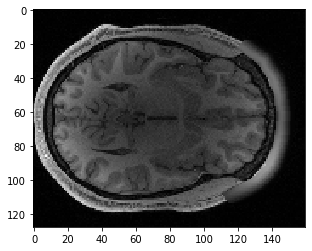

In [0]:
plt.imshow(lr[:,:,75], cmap='gray')

Ploting 2D image from generated SR scan.

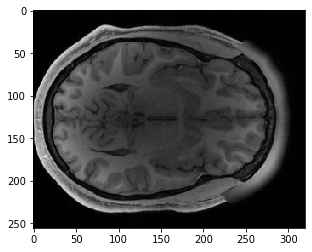

In [0]:
plt.imshow(sr[:,:,150], cmap='gray')

Ploting 2D image from the original scan.

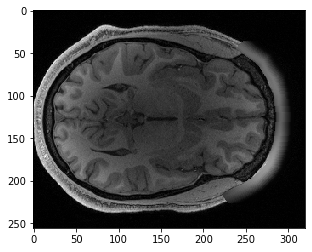

In [0]:
plt.imshow(hr[:,:,150], cmap='gray')